In [1]:
password = 'sandy9706' # 본인의 DB password

In [2]:
import pandas as pd
import numpy as np
import time, json, requests 
from datetime import datetime, timedelta, date

import pymysql # python에서 mysql을 사용하는 패키지

import sqlalchemy # sql 접근 및 관리를 도와주는 패키지
from sqlalchemy import create_engine

In [3]:
server = '127.0.0.1' # local server
user = 'root' # user name
password = password # 개인 password
db = 'mydb_1' # DB 이름

# sqlalchemy의 create_engine을 이용해 DB 연결
engine = create_engine('mysql+pymysql://{}:{}@{}/{}?charset=utf8'.format(user,password,server,db))

* getDateRange() : 시작일과 종료일 사이의 주말을 제외한 날짜 리스트를 구하는 함수
  > 리턴값 : 기간 내 모든 일자의 datetime object 리스트 객체

In [4]:
def getDateRange(st_date, end_date): # 기간 시작일, 기간 종료일을 파라미터로 받음
    print(st_date)
    print(int((end_date - st_date).days) + 1)
    for n in range(int((end_date - st_date).days) + 1): # 수집 기간을 구한 후 해당하는 기간만큼 for문 수행
        # print(st_date + timedelta(days=n))
        yield st_date + timedelta(days=n) # yield : 함수를 Generator로 만들고 변수를 지정하는 명령어

In [5]:
# str 형식으로 시작 날짜(st_dt)와 종료 날짜(end_dt)를 지정ㅎ
st_dt = '20220501'
end_dt = '20220510'
# 입력받은 날짜를 datetime.date(Y, m, d) 형식으로 변환
sdate = datetime.strptime(st_dt, '%Y%m%d').date()
edate = datetime.strptime(end_dt, '%Y%m%d').date()

dt_idx = [] # 수집 기간의 날짜
for dt in getDateRange(sdate, edate):
    if dt.isoweekday() < 6: # isoweekday : 요일 번호 추출 (6 이하인 경우 평일을 의미)
        dt_idx.append(dt.strftime("%Y%m%d")) # 조건을 만족했다면 dt_idx 리스트에 날짜를 저장

2022-05-01
10


In [6]:
print(dt_idx) # 입력된 날짜가 평일인 경우 출력

['20220502', '20220503', '20220504', '20220505', '20220506', '20220509', '20220510']


In [7]:
def getKRXPrice(mktId, st_dt, end_dt):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36",
        "X-Requested-With": "XMLHttpRequest",
        "Referer": "http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020103"
    }
    # 수집 기간 설정
    sdate = datetime.strptime(st_dt, '%Y%m%d').date()
    edate = datetime.strptime(end_dt, '%Y%m%d').date()
    dt_idx = [] # 수집 기간의 날짜
    for dt in getDateRange(sdate, edate):
        if dt.isoweekday() < 6:
            dt_idx.append(dt.strftime("%Y%m%d"))
    
    daily = []
    for dt in dt_idx:
        # 날짜별 전종목 일봉 불러오기
        p_data = {
            'bld': 'dbms/MDC/STAT/standard/MDCSTAT01501',
            'mktId': mktId,
            'trdDd': dt,
            'share': '1',
            'money': '1',
            'csvxls_isNo': 'false'
        }
        url = "http://data.krx.co.kr/comm/bldAttendant/getJsonData.cmd"
        res = requests.post(url, headers=headers, data=p_data)
        html_text = res.content
        html_json = json.loads(html_text)
        html_jsons = html_json['OutBlock_1']
        
        if len(html_jsons) > 0:
            for html_json in html_jsons:
                if html_json['TDD_OPNPRC'] == '-': # 시장이 열리지 않아 값이 없는 경우
                    continue

                ISU_SRT_CD = html_json['ISU_SRT_CD']
                ISU_ABBRV = html_json['ISU_ABBRV']
                TRD_DD = datetime.strptime(dt,'%Y%m%d').strftime('%Y-%m-%d')

                FLUC_RT = float(html_json['FLUC_RT'].replace(',',''))/100
                TDD_CLSPRC = int(html_json['TDD_CLSPRC'].replace(',',''))
                TDD_OPNPRC = int(html_json['TDD_OPNPRC'].replace(',',''))
                TDD_HGPRC = int(html_json['TDD_HGPRC'].replace(',',''))
                TDD_LWPRC = int(html_json['TDD_LWPRC'].replace(',',''))

                ACC_TRDVOL = int(html_json['ACC_TRDVOL'].replace(',',''))
                ACC_TRDVAL = int(html_json['ACC_TRDVAL'].replace(',',''))
                MKTCAP = int(html_json['MKTCAP'].replace(',',''))
                LIST_SHRS = int(html_json['LIST_SHRS'].replace(',',''))

                daily.append((ISU_SRT_CD,ISU_ABBRV,TRD_DD,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,TDD_CLSPRC,ACC_TRDVOL,FLUC_RT,ACC_TRDVAL,MKTCAP,LIST_SHRS))
        else:
            pass
    
    if len(daily) > 0:
        daily = pd.DataFrame(daily)
        daily.columns = ['stock_code','stock_name','date','open','high','low','close','volume','change','ACC_TRDVAL','MKTCAP','LIST_SHRS']
        daily = daily.sort_values(by='date').reset_index(drop=True)
        return daily
    else:
        return pd.DataFrame()

In [8]:
pr_df = getKRXPrice('STK', '20220503', '20220510')

2022-05-03
8


In [9]:
pr_df

,stock_code,stock_name,date,open,high,low,close,volume,change,ACC_TRDVAL,MKTCAP,LIST_SHRS
0,095570,AJ네트웍스,2022-05-03,6590,6750,6570,6570,44940,-0.0120,298878030,307622478150,46822295
1,000227,유유제약2우B,2022-05-03,19400,19500,19400,19450,1249,0.0026,24316750,6332142000,325560
2,001200,유진투자증권,2022-05-03,3270,3285,3250,3270,92392,0.0000,301701785,316753186860,96866418
3,000100,유한양행,2022-05-03,61000,61000,59900,60500,192750,-0.0066,11664325900,4430504298000,73231476
4,000105,유한양행우,2022-05-03,58600,58600,57800,58200,494,-0.0017,28640300,68730708000,1180940
...,...,...,...,...,...,...,...,...,...,...,...,...
4695,018500,동원금속,2022-05-10,935,970,920,950,401350,0.0117,379939268,44417186350,46754933
4696,006040,동원산업,2022-05-10,231000,240000,230500,239000,5974,0.0170,1407594000,878956199000,3677641
4697,030720,동원수산,2022-05-10,11550,12000,11300,11600,317927,-0.0043,3686219950,53984138000,4653805
4698,282690,동아타이어,2022-05-10,12400,12600,12100,12550,40862,0.0121,503978650,172349338250,13733015


In [10]:
pr_df.to_sql(name='kospi_unadj1',con=engine,if_exists='append',index=False,
             dtype = { # sql에 저장할 때, 데이터 유형도 설정
                 'stock_code' : sqlalchemy.types.VARCHAR(10),
                 'stock_name' : sqlalchemy.types.TEXT(),
                 'date' : sqlalchemy.types.DATE(),
                 'open' : sqlalchemy.types.BIGINT(),
                 'high' : sqlalchemy.types.BIGINT(),
                 'low' : sqlalchemy.types.BIGINT(),
                 'close' : sqlalchemy.types.BIGINT(),
                 'volume' : sqlalchemy.types.BIGINT(),
                 'change' : sqlalchemy.types.FLOAT(),
                 'ACC_TRDVAL' : sqlalchemy.types.BIGINT(),
                 'MKTCAP' : sqlalchemy.types.BIGINT(),
                 'LIST_SHRS' : sqlalchemy.types.BIGINT()                 
             }
            )

In [11]:
# DB 접속 해제
engine.dispose()
#cur.close()
#conn.close()

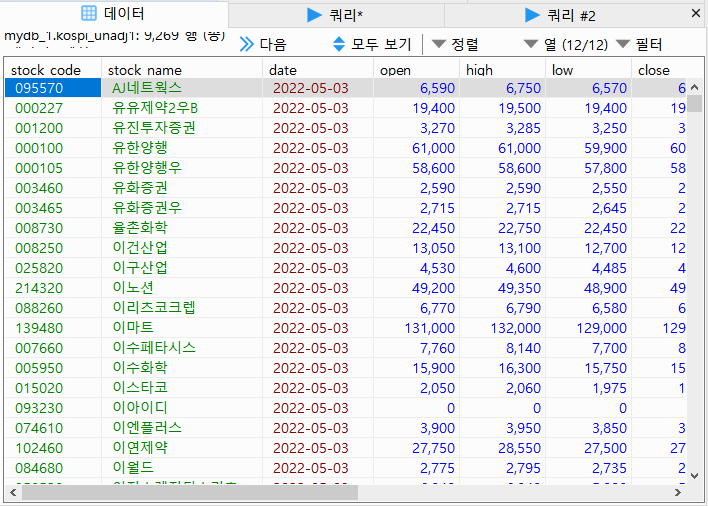